https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

This notebook is a simple LightGBM model only taking into account that there are a control group in our database.\
All data analysis is donne in the "MoA data analysyis" notebook.\
After, in another notebook, we will do a LightGBM using PCA and developping new variables.

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import lightgbm as lgb

#Path to save the output
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\results 2\\'

In [2]:
#load the Data
train_features = pd.read_csv('train_features.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_features = reduce_mem_usage(train_features)
train_targets_scored = reduce_mem_usage(train_targets_scored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [5]:
'''
Before start studying the variables, lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)

In [7]:
'''
For the validation and test, we will remove just the column 'cp_type'.
However, we will not delete the observations. 
Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.
'''

validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()

To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

In [9]:
#Lets start modeling!
#LightGBM

#Some adjustments so we can rum the lightGBM
train_x = train_features_without_control.drop(['sig_id', 'cp_type'], axis = 1).copy()
test_x = validation_features_without_control.drop(['sig_id'], axis = 1).copy()
test_x_control = validation_features_control.copy()
holdout_x = test_features_without_control.drop(['sig_id'], axis = 1).copy()
holdout_x_control = test_features_control.copy()

train_y = train_labels_without_control.drop(['sig_id'], axis = 1)
test_y = validation_labels_set.copy()


train_x['cp_dose'] = train_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)
test_x['cp_dose'] = test_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)

In [10]:
def print_time_to_end(progress_count, step_size, already_read, full_db_size):
    '''
    progress_check = print_time_to_end(progress_count = progress_check, step_size = progress_mult
                            , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))
    '''
#     progress += 1   #Changed to satisfy both situation if loading or not a saved progress.
    if already_read == progress_count * step_size:
        print()
        progress_per = round(already_read / full_db_size, 4)
        print(progress_per)
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        return 1 #Increase progress_count
    
    return 0 #Don't increase progress_count

In [11]:
def loss_train_validation(db, rotation_x, save_to):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    #Plot train and validation log loss
    fig, ax = plt.subplots(figsize=(15, 10))
    #Train log loss:
    x = db['parameter']
    y = db['log_loss_train']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'black', zorder = 3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Train', va = 'center')

    #Validation log loss:
#     x = log_loss_hp['parameter']
    y = db['log_loss_validation']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'dashed')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s=64, color='white', zorder=2)
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Validation', va = 'center')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(rotation = rotation_x)

    print()
    print('Smallest log loss:', round(db['log_loss_validation'].min(), 4))
    print('Smallest log loss parameter:', db[np.in1d(db['log_loss_validation'], db['log_loss_validation'].min())]['parameter'].values[0])
    log_loss_hp.to_csv(save_to, index = False)


Smallest log loss: 0.0162
Smallest log loss parameter: 0.725


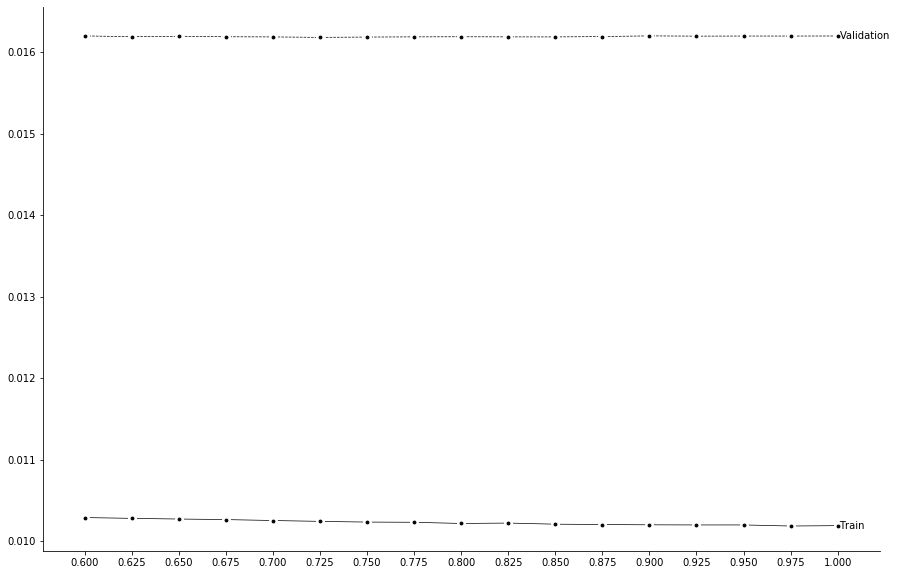

In [12]:
#Modeling  
#Hyperparameterization: feature_fraction
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_feature_fraction_aux.csv"
save_file_final = path_holdout + "log_loss_feature_fraction_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 3).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1]
for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": parameter,
                "learning_rate": 0.0165,
                "lambda_l2": 0.11,
                'num_leaves': 7,
                "min_data_in_leaf": 200,
                "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)


0.7416
Elapsed: 00:29:05
Total run time: 00:39:13
Time to finish: 00:10:08


0.7754
Elapsed: 00:58:46
Total run time: 01:15:47
Time to finish: 00:17:01


0.8091
Elapsed: 01:25:43
Total run time: 01:45:56
Time to finish: 00:20:13


0.8428
Elapsed: 01:50:44
Total run time: 02:11:23
Time to finish: 00:20:39


0.8765
Elapsed: 02:15:51
Total run time: 02:34:59
Time to finish: 00:19:08


0.9102
Elapsed: 02:40:43
Total run time: 02:56:34
Time to finish: 00:15:51


0.9439
Elapsed: 03:06:13
Total run time: 03:17:17
Time to finish: 00:11:04


0.9776
Elapsed: 03:30:51
Total run time: 03:35:41
Time to finish: 00:04:50


Smallest log loss: 0.016
Smallest log loss parameter: 0.0255


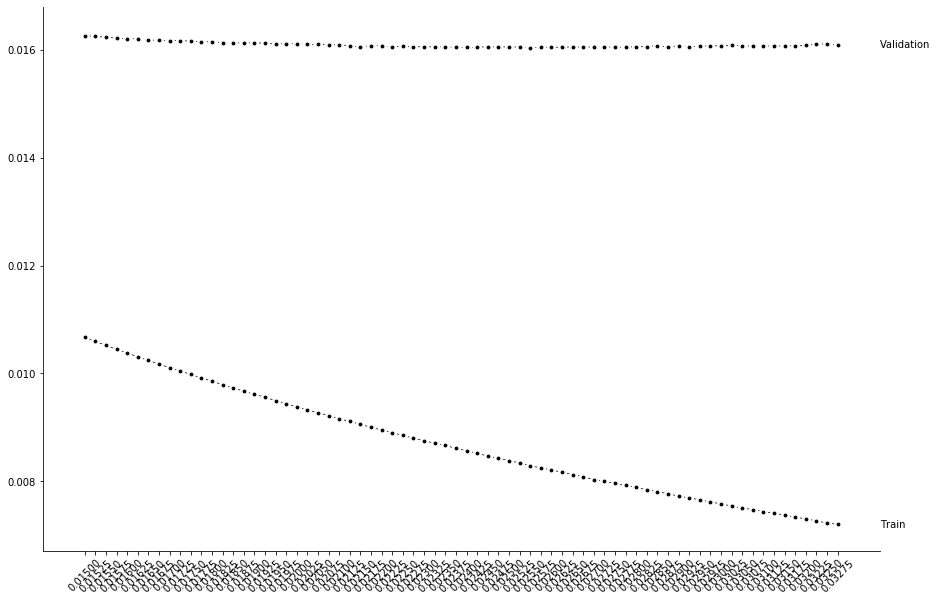

In [35]:
#Modeling  
#Hyperparameterization: learning_rate
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_learning_rate_aux.csv"
save_file_final = path_holdout + "log_loss_learning_rate_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 5).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [0.015, 0.01525, 0.0155, 0.01575, 0.016, 0.01625, 0.0165, 0.01675, 0.017, 0.01725, 0.0175, 0.01775
                 , 0.018, 0.01825, 0.01850, 0.01875, 0.019, 0.01925, 0.01950, 0.01975, 0.020, 0.02025, 0.02050, 0.02075
                 , 0.021, 0.02125, 0.02150, 0.02175, 0.022, 0.02225, 0.02250, 0.02275, 0.023, 0.02325, 0.02350, 0.02375
                 , 0.024, 0.02425, 0.02450, 0.02475, 0.025, 0.02525, 0.02550, 0.02575, 0.026, 0.02625, 0.02650, 0.02675
                 , 0.027, 0.02725, 0.02750, 0.02775, 0.028, 0.02825, 0.02850, 0.02875, 0.029, 0.02925, 0.02950, 0.02975
                 , 0.030, 0.03025, 0.03050, 0.03075, 0.031, 0.03125, 0.03150, 0.03175, 0.032, 0.03225, 0.03250, 0.03275]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": parameter, #0.0165
                "lambda_l2": 0.11,
                'num_leaves': 7,
                "min_data_in_leaf": 200,
                "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.0592
Elapsed: 00:24:42
Total run time: 06:57:14
Time to finish: 06:32:32


0.1184
Elapsed: 00:49:42
Total run time: 06:59:46
Time to finish: 06:10:04


0.1776
Elapsed: 01:14:20
Total run time: 06:58:33
Time to finish: 05:44:13


0.2368
Elapsed: 01:39:04
Total run time: 06:58:21
Time to finish: 05:19:17


0.296
Elapsed: 02:03:50
Total run time: 06:58:21
Time to finish: 04:54:31


0.3552
Elapsed: 02:28:41
Total run time: 06:58:35
Time to finish: 04:29:54


0.4144
Elapsed: 02:53:31
Total run time: 06:58:43
Time to finish: 04:05:12


0.4736
Elapsed: 03:18:12
Total run time: 06:58:30
Time to finish: 03:40:18


0.5328
Elapsed: 03:42:58
Total run time: 06:58:29
Time to finish: 03:15:31


0.592
Elapsed: 04:07:40
Total run time: 06:58:21
Time to finish: 02:50:41


0.6512
Elapsed: 04:32:26
Total run time: 06:58:21
Time to finish: 02:25:55


0.7104
Elapsed: 04:57:06
Total run time: 06:58:13
Time to finish: 02:01:07


0.7696
Elapsed: 05:21:50
Total run time: 06:58:11
Time to finish: 01:36:21




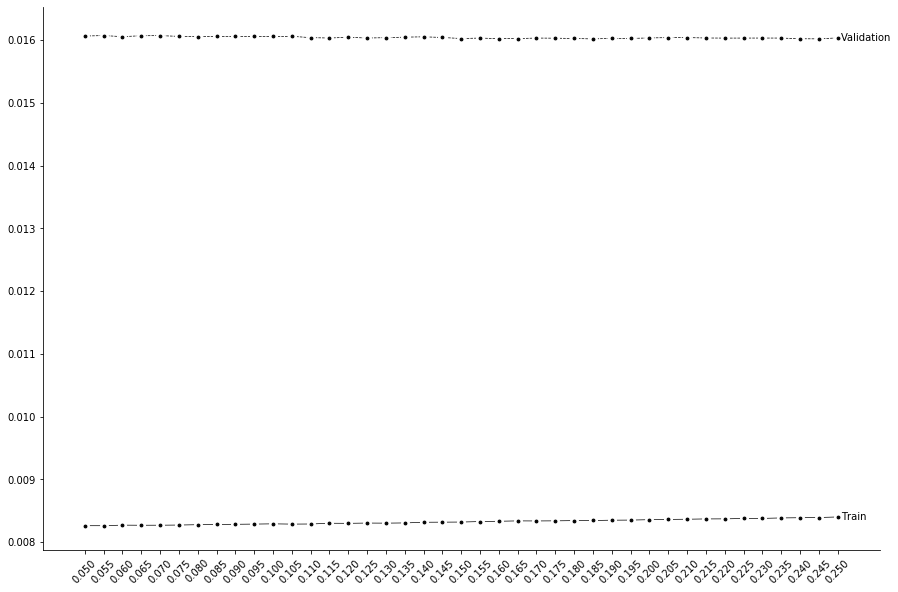

In [36]:
#Modeling  
#Hyperparameterization: lambda_l2
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_lambda_l2_aux.csv"
save_file_final = path_holdout + "log_loss_lambda_l2_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 3).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [0.050, 0.055, 0.060, 0.065, 0.070, 0.075, 0.080, 0.0850, 0.090, 0.095
                 , 0.100, 0.105, 0.110, 0.115, 0.120, 0.125, 0.130, 0.135, 0.140, 0.145
                 , 0.150, 0.155, 0.160, 0.165, 0.170, 0.175, 0.180, 0.185, 0.190, 0.195
                 , 0.200, 0.205, 0.210, 0.215, 0.220, 0.225, 0.230, 0.235, 0.240, 0.245
                 , 0.250]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": parameter, #0.11
                'num_leaves': 7,
                "min_data_in_leaf": 200,
                "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.8669
Elapsed: 00:12:16
Total run time: 00:14:09
Time to finish: 00:01:53


Smallest log loss: 0.016
Smallest log loss parameter: 6.0


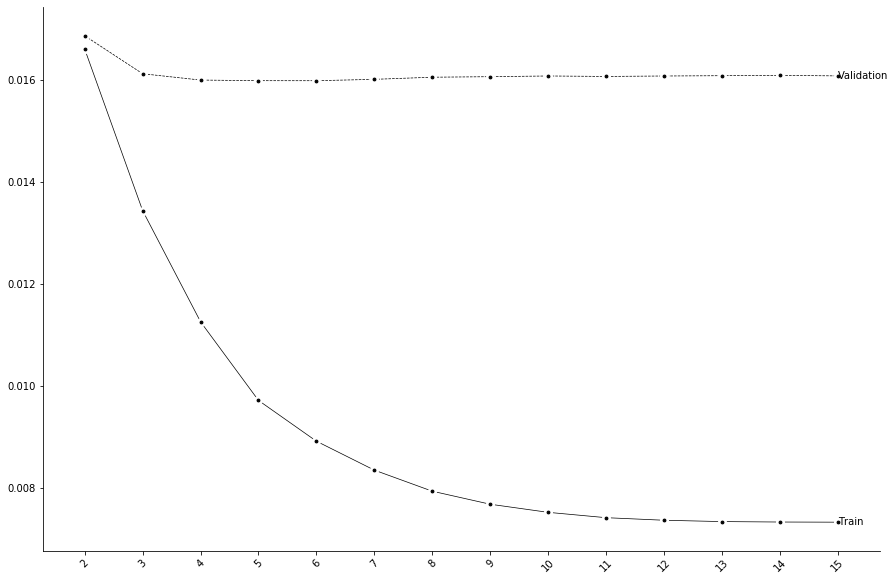

In [35]:
#Modeling  
#Hyperparameterization: num_leaves
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_num_leaves_aux.csv"
save_file_final = path_holdout + "log_loss_num_leaves_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': parameter, #7
                "min_data_in_leaf": 200,
                "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.9246
Elapsed: 00:23:33
Total run time: 00:25:28
Time to finish: 00:01:55


Smallest log loss: 0.016
Smallest log loss parameter: 425.0


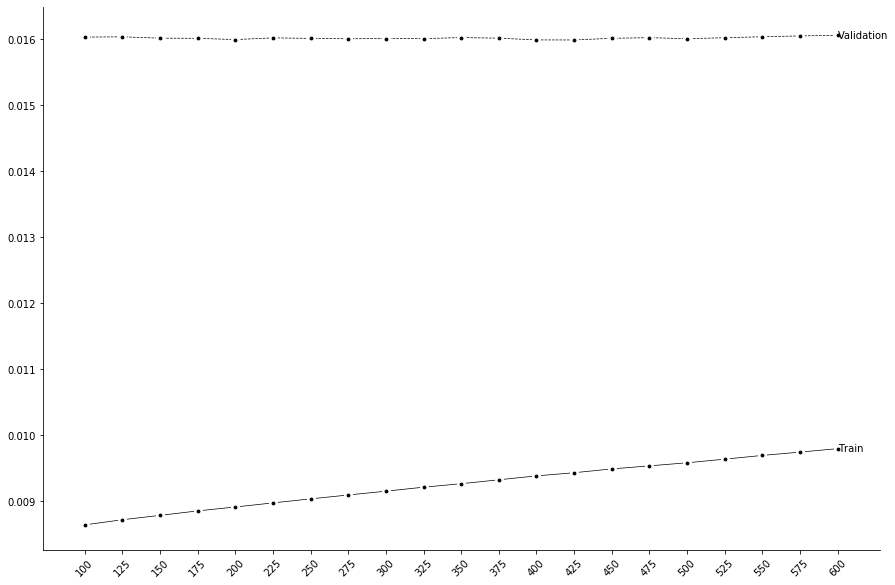

In [38]:
#Modeling  
#Hyperparameterization: min_data_in_leaf
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_min_data_in_leaf_aux.csv"
save_file_final = path_holdout + "log_loss_min_data_in_leaf_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475
                  , 500, 525, 550, 575, 600]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': 6,
                "min_data_in_leaf": parameter, #425
                "max_depth": 4
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)


0.2697
Elapsed: 00:22:11
Total run time: 01:22:15
Time to finish: 01:00:04


0.5394
Elapsed: 00:46:12
Total run time: 01:25:39
Time to finish: 00:39:27


0.8091
Elapsed: 01:11:05
Total run time: 01:27:51
Time to finish: 00:16:46


Smallest log loss: 0.016
Smallest log loss parameter: 4.0


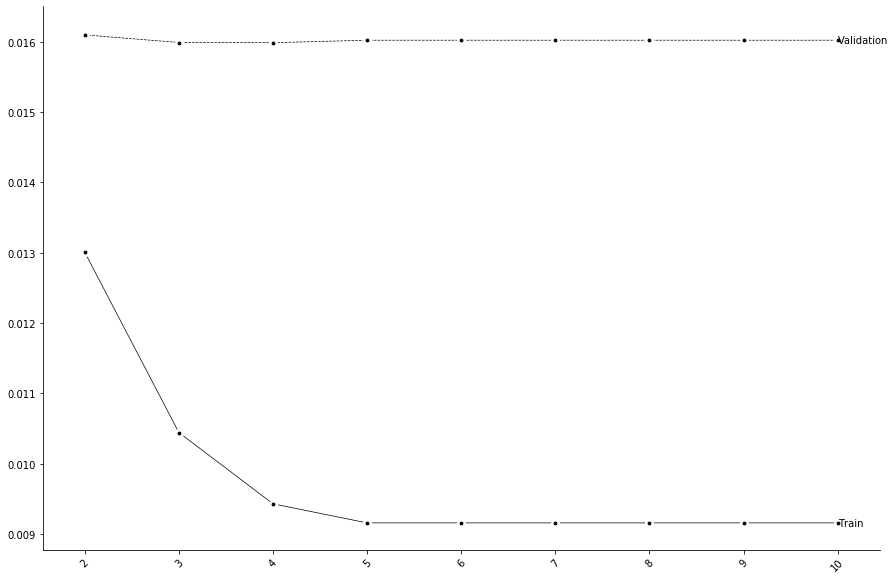

In [40]:
#Modeling  
#Hyperparameterization: max_depth
from sklearn.metrics import log_loss

save_file_aux = path_holdout + "log_loss_max_depth_aux.csv"
save_file_final = path_holdout + "log_loss_max_depth_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 500
start = time.time()

parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for parameter in hyperparameter:
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress += len(train_y.columns) #Changed to satisfy both situation if loading or not a saved progress.
        progress_check = int(progress / progress_mult) + 1
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []

        predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
        predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
        for col in train_y:

            lgb_params = {
                "objective": "binary",
                "metric": "binary_logloss",
                "boosting_type": "gbdt",
                'verbosity': 1,
                'seed': 1,
                "feature_fraction": 0.725,
                "learning_rate": 0.0255,
                "lambda_l2": 0.185,
                'num_leaves': 6,
                "min_data_in_leaf": 425,
                "max_depth": parameter
            }

            features = train_x.columns.tolist()
            lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
            model = lgb.train(train_set = lgb_train, params = lgb_params)

            #Prediction train
            predicted_MoA_train_aux = []
            predicted_MoA_train_aux = model.predict(train_x)
            predicted_MoA_train[col] = predicted_MoA_train_aux
            log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

            #Prediction validation
            predicted_MoA_test_aux = []
            predicted_MoA_test_aux = model.predict(test_x)
            predicted_MoA_validation[col] = predicted_MoA_test_aux
            #Adjust the result considering the control group
            for i in range(len(test_x)):
                if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
                    predicted_MoA_validation.loc[i, col] = 0
            log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
            #Running time
            progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
            progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))

        log_loss_train.append(np.mean(log_loss_train_aux))
        log_loss_validation.append(np.mean(log_loss_validation_aux))

        #Save progress
        parameters_tested.append(parameter)
        log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

In [104]:
#Modeling  
#Hyperparameterization: Final
from sklearn.metrics import log_loss

progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 100
start = time.time()

log_loss_train = []
log_loss_validation = []

log_loss_train_aux = []
log_loss_validation_aux = []

predicted_MoA_train = pd.DataFrame(train_features_without_control['sig_id'])
predicted_MoA_validation = pd.DataFrame(test_x_control['sig_id'])
for col in train_y:

    lgb_params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        'verbosity': 1,
        'seed': 1,
        "feature_fraction": 0.725,
        "learning_rate": 0.0255,
        "lambda_l2": 0.185,
        'num_leaves': 6,
        "min_data_in_leaf": 425,
        "max_depth": 4
        }

    features = train_x.columns.tolist()
    lgb_train = lgb.Dataset(data = train_x, label = train_y[col], feature_name = features)
    model = lgb.train(train_set = lgb_train, params = lgb_params)

    #Prediction train
    predicted_MoA_train_aux = []
    predicted_MoA_train_aux = model.predict(train_x)
    predicted_MoA_train[col] = predicted_MoA_train_aux
    log_loss_train_aux.append(log_loss(train_y[col], predicted_MoA_train[col], labels = [0, 1]))

    #Prediction validation
    predicted_MoA_test_aux = []
    predicted_MoA_test_aux = model.predict(test_x)
    predicted_MoA_validation[col] = predicted_MoA_test_aux
    #Adjust the result considering the control group
    for i in range(len(test_x)):
        if test_x_control.loc[i, 'cp_type'] == 'ctl_vehicle':
            predicted_MoA_validation.loc[i, col] = 0
    log_loss_validation_aux.append(log_loss(test_y[col], predicted_MoA_validation[col], labels = [0, 1]))
            
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                                , already_read = progress, full_db_size = len(train_y.columns))


    log_loss_db = pd.DataFrame(data = [train_y.columns.values, log_loss_train_aux, log_loss_validation_aux])
    log_loss_db = log_loss_db.transpose()
    log_loss_db.columns = ['MoA', 'log_loss_train', 'log_loss_validation']

    
#Save predictions
predicted_MoA_train.to_csv(path_holdout + 'predicted_MoA_train.csv', index = False)
predicted_MoA_validation.to_csv(path_holdout + 'predicted_MoA_validation.csv', index = False)
log_loss_db.to_csv(path_holdout + 'log_loss_by_col.csv', index = False)

#Show log loss
display(log_loss_db)

print()
print('Log loss Train:', round(log_loss_db['log_loss_train'].mean(), 6))
print('Log loss Validation:', round(log_loss_db['log_loss_validation'].mean(), 6))


0.4854
Elapsed: 00:04:41
Total run time: 00:09:39
Time to finish: 00:04:58


0.9709
Elapsed: 00:09:25
Total run time: 00:09:42
Time to finish: 00:00:17



,MoA,log_loss_train,log_loss_validation
0,5-alpha_reductase_inhibitor,0.0003106,0.00964452
1,11-beta-hsd1_inhibitor,0.000803356,0.00369385
2,acat_inhibitor,0.00126171,0.00887769
3,acetylcholine_receptor_agonist,0.0372458,0.0430267
4,acetylcholine_receptor_antagonist,0.0609037,0.0609443
...,...,...,...
201,ubiquitin_specific_protease_inhibitor,7.03539e-05,0.0120522
202,vegfr_inhibitor,0.018287,0.0344037
203,vitamin_b,0.00131452,0.00869277
204,vitamin_d_receptor_agonist,0.0014446,0.00784182



Log loss Train: 0.009432
Log loss Validation: 0.015985


In [227]:
#Load model's result
predicted_MoA_train = pd.read_csv(path_holdout + 'predicted_MoA_train.csv')
predicted_MoA_validation = pd.read_csv(path_holdout + 'predicted_MoA_validation.csv')
log_loss_by_col = pd.read_csv(path_holdout + 'log_loss_by_col.csv')

In [526]:
'''
A drug has at most 7 mechanisms of action. Therefore, lets set to zero the predictions most closer to zero.
'''
def db_nsmallest_row(db, n):
    sig_id = pd.DataFrame(db['sig_id'])
    db_aux = db.drop(['sig_id'], axis = 1).copy()
    new_db = []
    
    for i in range(len(db_aux)):
        db_aux_values = db_aux.iloc[i].values
        nsmallest = db_aux_values[np.argpartition(db_aux_values, n)[n]]
        condition = db_aux[i:i + 1].values < nsmallest
        db_aux_values[condition[0]] = 0
        new_db.append(db_aux_values)
        
    new_db = pd.DataFrame(data = new_db)  
    new_db.columns = db_aux.columns
    return sig_id.join(db_aux)
  
def log_loss_mean(db_real, db_prediction):
    log_loss_mean_aux = []
    for col in predicted_MoA_train_filtered.drop('sig_id', axis = 1):
        log_loss_col = log_loss(db_real[col], db_prediction[col], labels = [0, 1])
        log_loss_mean_aux.append(log_loss_col.mean())
    return np.mean(log_loss_mean_aux)


Smallest log loss: 0.016
Smallest log loss parameter: 0.0


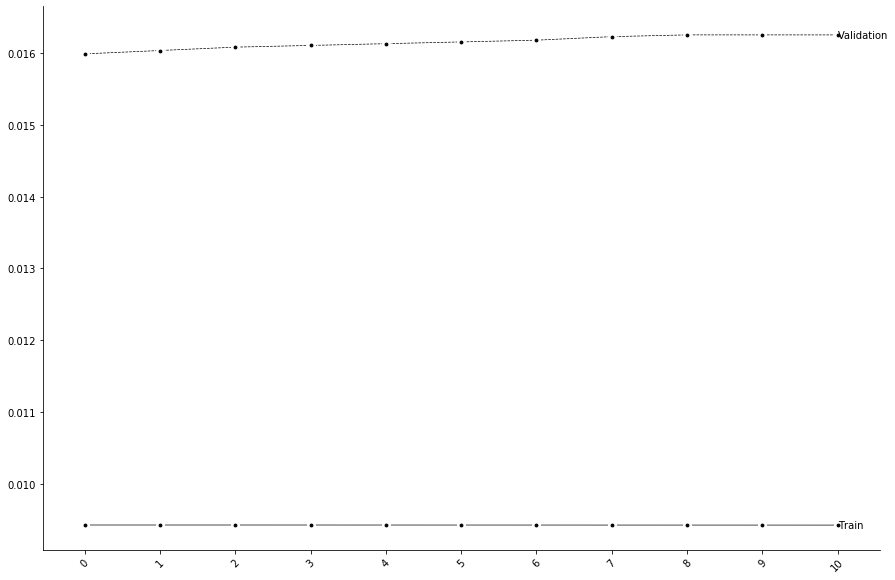

In [527]:
from sklearn.metrics import log_loss
save_file_aux = path_holdout + "log_loss_nsmallest_row_aux.csv"
save_file_final = path_holdout + "log_loss_nsmallest_row_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load
  
parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]    

for parameter in hyperparameter:
    if parameter in load_parameter: 
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []
        
        predicted_MoA_train_filtered = db_nsmallest_row(predicted_MoA_train, parameter)
        predicted_MoA_validation_filtered = db_nsmallest_row(predicted_MoA_validation, parameter) 

        log_loss_train.append(log_loss_mean(train_y, predicted_MoA_train_filtered))
        log_loss_validation.append(log_loss_mean(test_y, predicted_MoA_validation_filtered))
    
    #Save progress
    parameters_tested.append(parameter)
    log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
    log_loss_hp_aux = log_loss_hp_aux.transpose()
    log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
    log_loss_hp_aux.to_csv(save_file_aux, index = False)
   
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)    

This strategy did not work. 

This occurs because our model was by MoA and not by drug. Hence, a small MoA probability may imply that all probabilities from that model are small, but not necessarily that the drug has a smaller probability of having that MoA.

Therefore, lets apply zeros by Moa and not by drug.

In [389]:
#First, lets see the participation of each MoA en our database.
col_participation_aux = []

for col in train_y:
    col_participation_aux.append(train_y[col].sum()/len(train_y))

col_participation = pd.DataFrame(data = [train_y.columns, col_participation_aux])
col_participation = col_participation.transpose()
col_participation.columns = ['MoA', 'participation']
print('Largest MoA participation:', col_participation['participation'].max())
print('Smallest MoA participation:', col_participation['participation'].min())

Largest MoA participation: 0.039087391898042785
Smallest MoA participation: 5.689576695493855e-05


We can see that a mechanism of action may have at most 4% of participation.
We do not have any information about the MoAs from our test database (maybe actually all drugs in the test have the same MoA).Having said that, lets use a condition based on the length of the database and on the participation of each MoA.

In [534]:
def db_nsmallest_column(db, multiplicator):
    new_db = pd.DataFrame(db['sig_id']).copy()
    db_aux = db.drop(['sig_id'], axis = 1).copy()

    for col in db_aux:
        db_aux_values = db_aux[col].values
        MoA_participation = col_participation[np.in1d(col_participation['MoA'], col)]['participation'].values[0]
        n = int(min(MoA_participation*len(db)*multiplicator, len(db) - 1))
        nsmallest = db_aux_values[np.argpartition(db_aux_values, n)[n]]
        condition = db_aux_values < nsmallest
        db_aux_values[condition] = 0
        db_aux_db = pd.DataFrame(data = db_aux_values)
        db_aux_db.columns = [col]
        new_db = new_db.join(db_aux_db)

    return new_db


Smallest log loss: 0.016
Smallest log loss parameter: 0.0


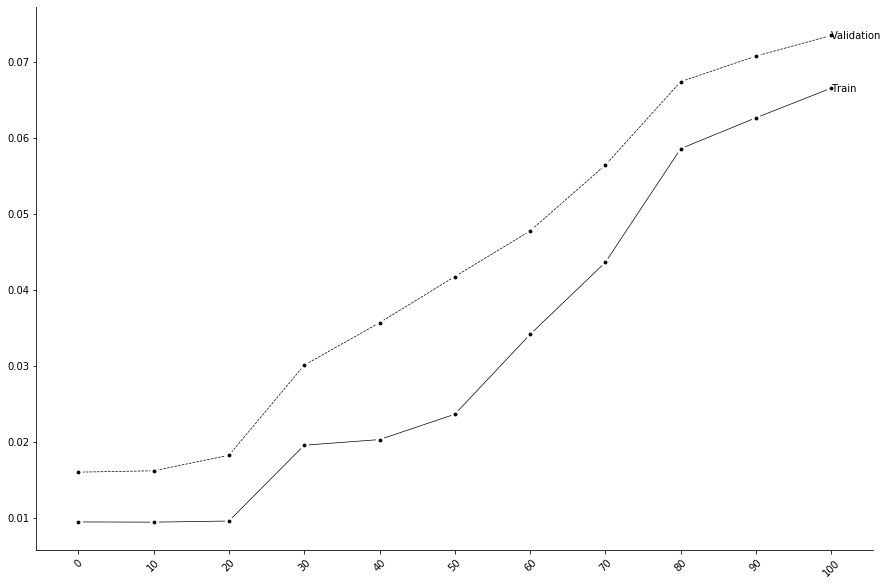

In [535]:
from sklearn.metrics import log_loss
save_file_aux = path_holdout + "log_loss_nsmallest_column_aux.csv"
save_file_final = path_holdout + "log_loss_nsmallest_column_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load
  
parameters_tested = []  #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]    

for parameter in hyperparameter:
    if parameter in load_parameter: 
        #Load stoped process
        parameters_tested.append(parameter)
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        
    else:
        log_loss_train_aux = []
        log_loss_validation_aux = []
        
        predicted_MoA_train_filtered = db_nsmallest_column(predicted_MoA_train, parameter)
        predicted_MoA_validation_filtered = db_nsmallest_column(predicted_MoA_validation, parameter) 

        log_loss_train.append(log_loss_mean(train_y, predicted_MoA_train_filtered))
        log_loss_validation.append(log_loss_mean(test_y, predicted_MoA_validation_filtered))
    
    #Save progress
    parameters_tested.append(parameter)
    log_loss_hp_aux = pd.DataFrame(data = [parameters_tested, log_loss_train, log_loss_validation])
    log_loss_hp_aux = log_loss_hp_aux.transpose()
    log_loss_hp_aux.columns = ['parameter', 'log_loss_train', 'log_loss_validation']
    log_loss_hp_aux.to_csv(save_file_aux, index = False)
   
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)    

This strategy did not work either./
herefore, if we want a better model, we need to work in variavel selection, maybe use PCA since we have a multi classification problem, and in new variables. We can also try another model as Feeddorward neural networks.